# Explore confidence scores with Whisper

In [1]:
from utils import *
from confidence_utils import *

from datasets import load_dataset
from IPython.display import HTML as html_print
import matplotlib.pyplot as plt

## 1. Load data

In [2]:
fleurs_en = load_dataset("google/fleurs", "en_us")
fleurs_en = fleurs_en.remove_columns(['id', 'num_samples', 'path', 'gender', 'lang_id', 'language', 'lang_group_id'])
fleurs_en = fleurs_en['train']#.select(range(100))

Found cached dataset fleurs (/home/antonin/.cache/huggingface/datasets/google___fleurs/en_us/2.0.0/aabb39fb29739c495517ac904e2886819b6e344702f0a5b5283cb178b087c94a)


  0%|          | 0/3 [00:00<?, ?it/s]

## 2. Load models

In [3]:
processor_en, model_en = load_whisper_with_confidence_scores('openai/whisper-base', 'English')

## 3. Run inference test

In [4]:
model_en.config.forced_decoder_ids = processor_en.get_decoder_prompt_ids(language = "en", task = "transcribe")
fleurs_en = fleurs_en.map(map_to_pred_and_confidence_scores, 
    fn_kwargs={"processor": processor_en, "model": model_en, "lang": "en"}, 
    batched=True, \
    remove_columns=['audio'], 
    batch_size = 1)
fleurs_en

  0%|          | 0/2602 [00:00<?, ?ba/s]

/home/antonin/Capstone-Audio-Transcription/whisper/confidence_utils.py:433: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 448 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


Dataset({
    features: ['transcription', 'raw_transcription', 'string_pred', 'tokens_pred', 'probs_tokens_pred', 'ground_truth', 'wer'],
    num_rows: 2602
})

## 4. Save processed data with confidence indicators

In [5]:
fleurs_en.save_to_disk(os.path.join(predictions_confidence_path, 'fleurs_en'))

## 5. Load processed data with confidence indicators

In [2]:
fleurs_en = load_from_disk(os.path.join(predictions_confidence_path, 'fleurs_en'))
fleurs_en

Dataset({
    features: ['transcription', 'raw_transcription', 'string_pred', 'tokens_pred', 'probs_tokens_pred', 'ground_truth', 'wer'],
    num_rows: 2602
})

## 6. Display confidence colors

In [3]:
html_print(html_display_confidence(fleurs_en, range(10)))

## 7. Time to analyze

In [66]:
import pandas as pd
import seaborn as sns
from scipy import stats

In [74]:
# instantiate dict of heuristics
heuristics = dict({'wer':[], 'avg_prob_tokens':[]})

# fill dict
for row in fleurs_en:
    heuristics['wer'].append(row['wer'])
    heuristics['avg_prob_tokens'].append(np.mean(row['probs_tokens_pred']))

# export to pd dataframe
heuristics = pd.DataFrame.from_dict(heuristics)

# remove outliers
heuristics = heuristics[(np.abs(stats.zscore(heuristics)) < 3).all(axis=1)]

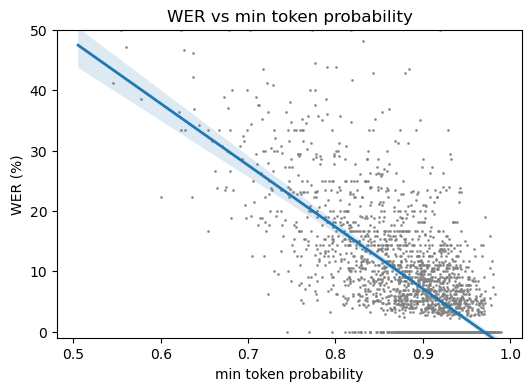

In [59]:
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.regplot(x = means_prob, y = wers, ci=100,
    scatter_kws = dict({'s':1, 'color': 'grey'}),
    line_kws = dict({'linewidth':2}),
    ax = ax)
ax.set_xlabel('min token probability')
ax.set_ylabel('WER (%)')
ax.set_ylim(-1,50)
ax.set_title('WER vs min token probability')
plt.show()

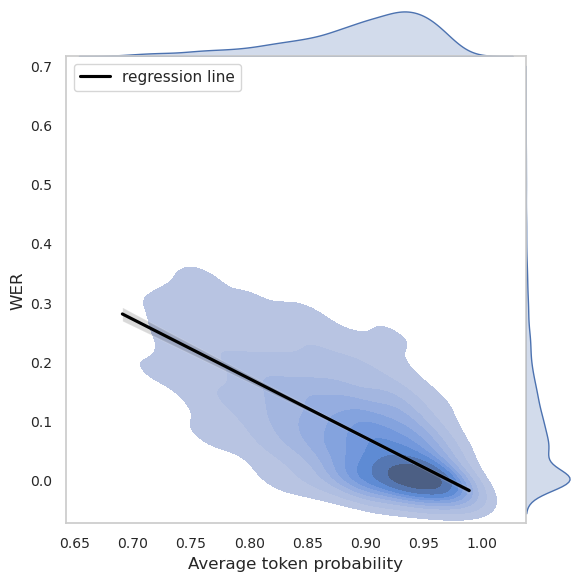

In [129]:
#sns.set(font_scale = 1.1)
sns.set_style("whitegrid", {'axes.grid' : False})
jp = sns.jointplot(data=heuristics, x="avg_prob_tokens", y="wer", 
              kind="kde", fill = True, #xlim = [0,3000], ylim = [0,1],
              ratio = 10, space = 0, marginal_ticks = False, palette = "mako"
             )
jp.plot_joint(sns.regplot, color="black", scatter=None, ci=95, label='regression line')
jp.set_axis_labels("Average token probability", "WER")
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend(loc = "upper left")

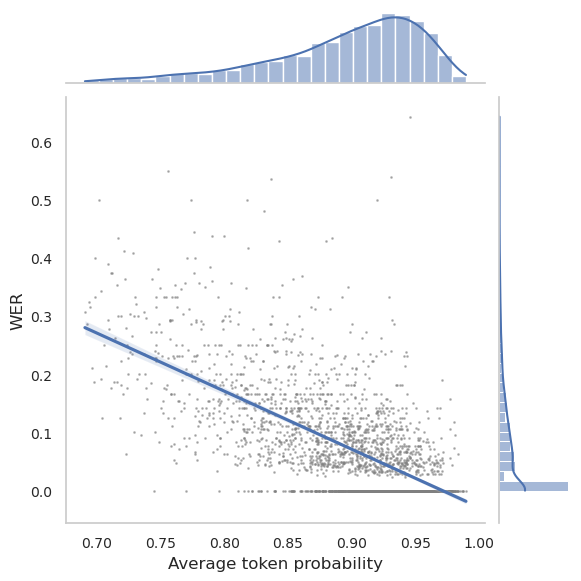

In [111]:
jp = sns.jointplot(data=heuristics, x="avg_prob_tokens", y="wer",  kind="reg", #scatter=None,
    scatter_kws = dict({'s':1, 'alpha':0.5, 'color': 'grey'}))
jp.set_axis_labels("Average token probability", "WER")
plt.tick_params(axis='both', which='major', labelsize=10)